## 多品种仓位初始化
多品种需要将仓位初始化的位置放在onBar启动后，并改为局部变量。

In [1]:
from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiSignalStrategy(CtaTemplate):
    className = 'MultiSignalStrategy'
    author = 'ChannelCMT'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    

    amWindow = 20
    initDays = 1
    # 策略参数
    smaPeriod = 18
    lmaPeriod = 23
    cciPeriod = 12
    rsiPeriod = 4
    rsiEntry = 12
    trailingPercent = 7
    threshold = 2

    # 策略变量
    transactionPrice = EMPTY_FLOAT # 记录成交价格
    fixedSize = 1 
    longStop = EMPTY_FLOAT
    shortStop = EMPTY_FLOAT
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'amWindow',
                 'rsiPeriod',
                 'cciPeriod',
                 'rsiEntry',
                 'smaPeriod',
                 'lmaPeriod',
                 'threshold',
                 'trailingPercent']  
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'transactionPrice',
               'fixedSize',
               'longStop',
               'shortStop']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(MultiSignalStrategy, self).__init__(ctaEngine, setting)
      
        self.bg30 = BarGenerator(self.onBar, 30, self.on30MinBar)
        self.bg30Dict = {
            sym: self.bg30
            for sym in self.symbolList
        }
        
        self.am30Dict = {
            sym: ArrayManager(size=self.amWindow*2)
            for sym in self.symbolList
        }
        
        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }
        
        self.am60Dict = {
            sym: ArrayManager(size=self.amWindow*2)
            for sym in self.symbolList
        }
        
        self.intraTradeHighDict = {}
        self.intraTradeLowDict = {}
        self.RSI = 0
        self.CCI = 0
        self.MA = 0
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        self.ctaEngine.initPosition(self)
        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        Longpos = symbol.replace('.','_')+"_LONG"
        Shortpos = symbol.replace('.','_')+"_SHORT"
        
        bg30 = self.bg30Dict[symbol]
        bg30.updateBar(bar)
        
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)
        
        # 洗价器
        if self.posDict[Longpos] == 0 and self.posDict[Shortpos] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[Longpos] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.intraTradeLowDict[symbol] = bar.low
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPercent/100)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[Longpos])

#         # 持有空头仓位
        elif self.posDict[Shortpos] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.intraTradeHighDict[symbol] = bar.high
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPercent/100)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[Shortpos])
        self.putEvent()

    def on30MinBar(self, bar):
        symbol = bar.vtSymbol
        
        am30 = self.am30Dict[symbol]
        am30.updateBar(bar)
        if not am30.inited:
            return
        
        cci = ta.CCI(am30.high, am30.low, am30.close, self.cciPeriod)
        rsi = ta.RSI(am30.close, self.rsiPeriod)
        rsiLong = 50 + self.rsiEntry
        rsiShort = 50 - self.rsiEntry
        
        if cci[-1]>10:
            self.CCI = 1
        elif cci[-1]<-10:
            self.CCI = -1
        else:
            self.CCI = 0
        
        if rsi[-1]>=rsiLong:
            self.RSI = 1
        elif rsi[-1]<=rsiShort:
            self.RSI = -1
        else:
            self.RSI = 0
        
        # 发出状态更新事件
        self.putEvent()

    def on60MinBar(self, bar):
        symbol = bar.vtSymbol
        
        Longpos = symbol.replace('.','_')+"_LONG"
        Shortpos = symbol.replace('.','_')+"_SHORT"
        
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)
        if not am60.inited:
            return
        
        SMA = ta.MA(am60.close, self.smaPeriod)
        LMA = ta.MA(am60.close, self.lmaPeriod)
        
        if SMA[-1]>LMA[-1]:
            self.MA = 1
        elif SMA[-1]<LMA[-1]:
            self.MA = -1
        else:
            self.MA = 0
        
        Signal = self.MA+self.CCI+self.RSI

        if Signal>=2:
            if (self.posDict[Longpos]==0) and (self.posDict[Shortpos]==0):
                self.buy(symbol,bar.close*1.1, self.fixedSize)
            elif self.posDict[Shortpos] > 0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.1, self.posDict[Shortpos])
                self.buy(symbol,bar.close*1.1, self.fixedSize)
            
        elif Signal<=-2:
            if (self.posDict[Longpos]==0) and (self.posDict[Shortpos]==0):
                self.short(symbol,bar.close*0.9, self.fixedSize)
            elif self.posDict[Longpos]>0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.9, self.fixedSize)
                self.short(symbol,bar.close*0.9, self.fixedSize)
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        self.transactionPrice = trade.price
        print(self.posDict)
#         pass

    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME

# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
engine.setStartDate('20180101',initDays=5)               # 设置回测用的数据起始日期
engine.setEndDate('20180630')
# 配置回测引擎参数
engine.setSlippage(0.2)     # 设置滑点为股指1跳
engine.setRate(1/1000)   # 设置手续费千1
engine.setSize(1)         # 设置合约大小 
engine.setPriceTick(0.1)    # 设置股指最小价格变动   
engine.setCapital(1000000)  # 设置回测本金
# 在引擎中创建策略对象
d = {'symbolList':[ 'tBTCUSD:bitfinex','tBCHUSD:bitfinex']}                    # 策略参数配置
engine.initStrategy(MultiSignalStrategy, d)    # 创建策略对象
engine.runBacktesting()

2018-07-14 14:57:25.056699	开始回测
2018-07-14 14:57:25.056699	策略初始化
2018-07-14 14:57:25.056699	载入历史数据。数据范围:[20171227,20180101)
2018-07-14 14:57:26.310419	载入完成，数据量：14339
2018-07-14 14:57:26.409319	策略初始化完成
2018-07-14 14:57:26.409319	策略启动完成
2018-07-14 14:57:26.410318	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-14 14:57:26.410318	载入历史数据。数据范围:[20180101,20180204)
2018-07-14 14:57:34.800752	载入完成，数据量：96634
2018-07-14 14:57:34.801751	当前回放数据:[20180101,20180204)
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tB

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
2018-07-14 14:58:03.383568	载入历史数据。数据范围:[20180517,20180620)
2018-07-14 14:58:10.917876	载入完成，数据量：89218
2018-07-14 14:58:10.953840	当前回放数据:[20180517,20180620)
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bi

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG

{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 1, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG': 0, 'tBCHUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1, 'tBCHUSD:bitfinex_LONG

In [4]:
# 显示前10条成交记录
for i in range(10000):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2018-01-01 00:01:00, Direction: 多, Price: 13330.0, Volume: 1
TradeID: 2, Time: 2018-01-01 00:01:00, Direction: 多, Price: 2401.1, Volume: 1
TradeID: 3, Time: 2018-01-01 09:52:00, Direction: 空, Price: 2305.8, Volume: 1
TradeID: 4, Time: 2018-01-01 13:01:00, Direction: 多, Price: 2358.9, Volume: 1
TradeID: 5, Time: 2018-01-01 19:01:00, Direction: 空, Price: 2370.1, Volume: 1
TradeID: 6, Time: 2018-01-01 19:01:00, Direction: 空, Price: 2370.1, Volume: 1
TradeID: 7, Time: 2018-01-01 19:11:00, Direction: 空, Price: 13187.0, Volume: 1
TradeID: 8, Time: 2018-01-01 21:01:00, Direction: 空, Price: 13155.0, Volume: 1
TradeID: 9, Time: 2018-01-02 06:01:00, Direction: 多, Price: 2345.8, Volume: 1
TradeID: 10, Time: 2018-01-02 06:01:00, Direction: 多, Price: 2345.8, Volume: 1
TradeID: 11, Time: 2018-01-02 08:30:00, Direction: 多, Price: 13757.0, Volume: 1
TradeID: 12, Time: 2018-01-02 11:01:00, Direction: 空, Price: 13514.0, Volume: 1
TradeID: 13, Time: 2018-01-02 12:01:00, Direction: 空, Pr

KeyError: '925'

## 查看绩效回测绩效

2018-07-14 15:05:22.914806	计算按日统计结果
2018-07-14 15:05:22.953766	------------------------------
2018-07-14 15:05:22.953766	首个交易日：	2018-01-01
2018-07-14 15:05:22.953766	最后交易日：	2018-06-30
2018-07-14 15:05:22.953766	总交易日：	181
2018-07-14 15:05:22.953766	盈利交易日	92
2018-07-14 15:05:22.953766	亏损交易日：	89
2018-07-14 15:05:22.953766	起始资金：	1000000
2018-07-14 15:05:22.953766	结束资金：	1,011,573.44
2018-07-14 15:05:22.953766	总收益率：	1.16%
2018-07-14 15:05:22.953766	年化收益：	1.53%
2018-07-14 15:05:22.953766	总盈亏：	11,573.44
2018-07-14 15:05:22.953766	最大回撤: 	-2,279.74
2018-07-14 15:05:22.953766	百分比最大回撤: -0.23%
2018-07-14 15:05:22.953766	总手续费：	4,511.42
2018-07-14 15:05:22.953766	总滑点：	184.8
2018-07-14 15:05:22.953766	总成交金额：	4,511,419.37
2018-07-14 15:05:22.953766	总成交笔数：	924
2018-07-14 15:05:22.953766	日均盈亏：	63.94
2018-07-14 15:05:22.953766	日均手续费：	24.92
2018-07-14 15:05:22.953766	日均滑点：	1.02
2018-07-14 15:05:22.953766	日均成交金额：	24,924.97
2018-07-14 15:05:22.953766	日均成交笔数：	5.1
2018-07-14 15:05:22.953766	日均收益率：	0.01%
2018-0

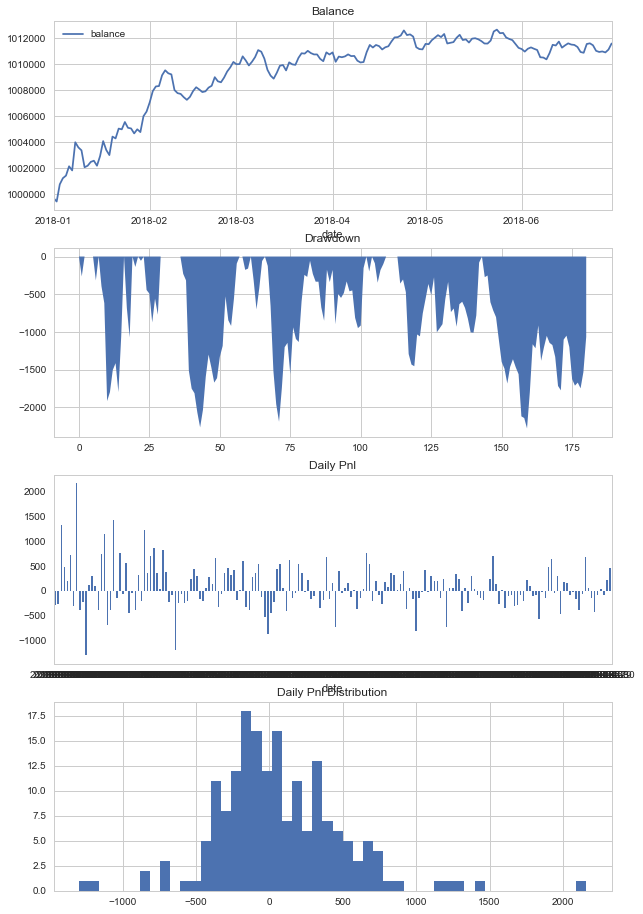

2018-07-14 15:05:24.757925	计算回测结果
2018-07-14 15:05:24.795887	------------------------------
2018-07-14 15:05:24.795887	第一笔交易：	2018-01-01 09:52:00
2018-07-14 15:05:24.795887	最后一笔交易：	2018-06-30 23:59:00
2018-07-14 15:05:24.795887	总交易次数：	463
2018-07-14 15:05:24.795887	总盈亏：	11,565.92
2018-07-14 15:05:24.795887	最大回撤: 	-2,867.39
2018-07-14 15:05:24.795887	平均每笔盈利：	24.98
2018-07-14 15:05:24.795887	平均每笔滑点：	0.4
2018-07-14 15:05:24.795887	平均每笔佣金：	9.76
2018-07-14 15:05:24.795887	胜率		41.68%
2018-07-14 15:05:24.795887	盈利交易平均值	208.45
2018-07-14 15:05:24.795887	亏损交易平均值	-106.16
2018-07-14 15:05:24.795887	盈亏比：	1.96


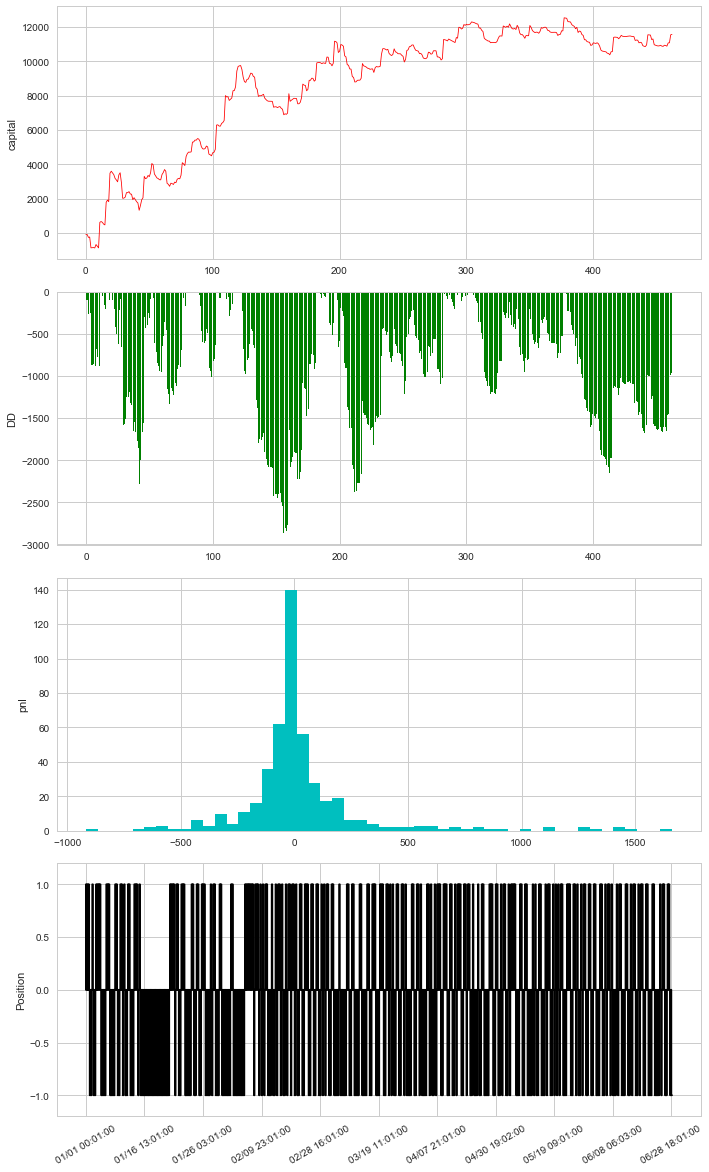

In [5]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [6]:
df = engine.calculateDailyResult()

2018-07-14 15:05:32.323200	计算按日统计结果


In [7]:
df1, result = engine.calculateDailyStatistics(df)

In [8]:
result

{'annualizedReturn': 1.5345992558893655,
 'dailyCommission': 24.924968889048326,
 'dailyNetPnl': 63.94163566205665,
 'dailyReturn': 0.0065130352389825225,
 'dailySlippage': 1.0209944751381217,
 'dailyTradeCount': 5.104972375690608,
 'dailyTurnover': 24924.968889048338,
 'endBalance': 1011573.4360548323,
 'endDate': datetime.date(2018, 6, 30),
 'lossDays': 89,
 'maxDdPercent': -0.2251282792123597,
 'maxDrawdown': -2279.7351999999955,
 'profitDays': 92,
 'returnStd': 0.043569040214042974,
 'sharpeRatio': 2.315853357330648,
 'startDate': datetime.date(2018, 1, 1),
 'totalCommission': 4511.419368917747,
 'totalDays': 181,
 'totalNetPnl': 11573.436054832253,
 'totalReturn': 1.1573436054832298,
 'totalSlippage': 184.80000000000004,
 'totalTradeCount': 924,
 'totalTurnover': 4511419.368917749}